In [1]:
import os
import sys
one_level_up_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(one_level_up_dir)
import jax._src.random as prng
import jax
from jax import config, jit
import jax.numpy as jnp
import jax.random as jr
import diffrax as dfx
import matplotlib.pyplot as plt
import optax as ox
import equinox as eqx
from gpdx.systems.nonlinear_dynamics import VanDerPol
from gpdx.control.trajectory_optimizers import *
from gpdx.control.cost_functions import QuadraticCost
from gpdx.control.mpc import *
# from gpdx.dataset import DiffEqDataset
from gpdx.nn.node import NeuralODE, EnsembleNeuralODE
from gpdx.nn.nnvectorfield import NeuralVectorField, EnsembleNeuralVectorField

from gpdx.fit import *
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
PRNGKey = prng.KeyArray
key = jr.PRNGKey(1237) 
key, subkey = jr.split(key)
%load_ext autoreload
%autoreload 2 
## mean optimal control posterior seed 1

## Define control problem and generate data to train NODE

In [2]:
from gpdx.control.control_task import DuffingStabilization
env = DuffingStabilization()
env


DuffingStabilization(
  real_system=DuffingOscillator(
    D_sys=2,
    D_control=1,
    solver=Dopri8(scan_kind=None),
    name='Duffing Oscillator',
    control_interpolator='linear',
    alpha=-1.0,
    beta=2.0,
    delta=0.2,
    gamma=1.0,
    omega=5.0
  ),
  D_sys=2,
  D_control=1,
  R=f64[1,1],
  Q=f64[2,2],
  x_star=f64[2],
  u_star=f64[1],
  y0=f64[2],
  t0=0.0,
  tf=5.0,
  Delta_t=0.05,
  measurement_noise_std=0.01,
  lb=-5.0,
  ub=5.0,
  state_cost=QuadraticCost(
    Q=f64[2,2],
    R=f64[1,1],
    x_star=f64[2],
    u_star=f64[1],
    transform=None
  ),
  termination_cost=QuadraticCost(
    Q=f64[2,2],
    R=f64[1,1],
    x_star=f64[2],
    u_star=f64[1],
    transform=None
  ),
  H=None,
  Q_f=f64[2,2],
  name='Van der Pol stabilization control task',
  S=1.0
)

## data generation

In [3]:
## data generation
num_trials = 10
t0 = env.t0
tf = env.tf
dt = env.Delta_t
dt0_dense = 1e-2 # 

num_initial_trials = 1
num_obs = int((tf-t0)/dt)
D_in, D_out = env.D_sys+ env.D_control, env.D_sys
noise = jnp.array([jnp.sqrt(env.measurement_noise_std) for _ in range(D_out)]) # sigma^2 = 0.05 in Hegde experiment 4.1

## ode params
stepsize_controller=dfx.PIDController(rtol=1e-4, atol=1e-5, jump_ts=None)
internal_solver = dfx.Dopri5() 
dt0_internal = 0.025

## neural network
ensemble_size = 5
data_per_ensemble = num_initial_trials
hidden_dim = 32
layer_sizes = (D_in, hidden_dim, hidden_dim, D_out)
activation = jax.nn.elu

## training
num_iters = 2_000
init_obs_noise = 0.5
batch_size = -1 # -1 or num_trials for no batching
lr = 0.0015
log_rate = 20

# MPC 
maxiter =20
H = 2
us_init = 0.*jr.normal(key=subkey**2, shape=(jnp.arange(0, H, env.Delta_t).shape[0], 1))

In [4]:
# initial state distribution
real_system = env.real_system
key, subkey = jr.split(key)

# randomly sample observation times. 
ts_uniform = jnp.concatenate([jnp.linspace(t0, tf, num_obs)[None] for _ in range(num_initial_trials)], axis=0)
ts = jnp.sort(ts_uniform, axis=1)
ts_dense = jnp.concatenate([jnp.linspace(env.t0, env.tf, int( ((1/dt0_dense))*(tf-t0)))[None] for _ in range(num_initial_trials)], axis=0)
freqs = jnp.arange(1,num_initial_trials+1)
indices = jnp.linspace(0.2, 1.5, num_initial_trials)
# us = jax.vmap(lambda t, i: 1*jnp.cos(5*t), in_axes=(0,0))(ts_dense, indices)[..., None] # original duffing input
us = jax.vmap(lambda t, i:1*jnp.cos(5.*jr.uniform(jr.PRNGKey(round(3**i)))*t+jr.normal(key)))(ts_dense, indices)[..., None]
key, subkey = jr.split(key)


# simulate data from real system
key, subkey = jr.split(key)
data, true_y0s = env.real_system.generate_synthetic_data(subkey,
                                           num_initial_trials,
                                           dt0=dt0_dense,
                                           ts=ts,
                                           us=us,
                                           obs_stddev=noise,
                                           ts_dense=ts_dense,
                                           x0_distribution=env.get_initial_condition,
                                           standardize_at_initialisation=False,
                                          )

## Train neural ODE

In [5]:
from gpdx.nn.nnvectorfield import EnsembleNeuralVectorField
from gpdx.nn.node import EnsembleNeuralODE
from gpdx.fit import fit_node
from gpdx.nn.node import mse_loss_ensemble


def train_network(data, key):
    key, subkey = jr.split(key)
    keys = jr.split(subkey, ensemble_size)


    ensemble_datasets = jax.vmap(get_batch, in_axes=(None, None, 0, None))(data, data.n, keys, False)
    print(ensemble_datasets.n, ensemble_datasets.ys.shape)
    key, subkey = jr.split(key)

    ensemble_vectorfield = EnsembleNeuralVectorField(
                                ensemble_size=ensemble_size,
                                layer_sizes=layer_sizes,
                                activation=activation,
                                D_sys=real_system.D_sys,
                                D_control=real_system.D_control,
                                key=key,)

    """ testing the neural ODE call with the newly created vectorfield class."""

    # initialize p(x0)
    x0_mean_init = ensemble_datasets.ys[:,:,0,:]
    x0_diag_raw = jnp.zeros_like(x0_mean_init)-1.

    ensemble_node = EnsembleNeuralODE(
                            ensemble_size=ensemble_size,
                            obs_noise_raw=jnp.log(jnp.exp(init_obs_noise)-1.),
                            x0_mean=x0_mean_init-1,
                            x0_diag_raw=x0_diag_raw,
                            vectorfield=ensemble_vectorfield,
                            solver=dfx.Dopri5(),
                            dt0=dt0_internal,
                            stepsize_controller=dfx.ConstantStepSize(),#dfx.PIDController(rtol=1e-3,atol=1e-5),
                            D_sys=real_system.D_sys,
                            D_control=real_system.D_control,
                            )

    optim = ox.adam(learning_rate=lr)

    opt_ensemble_node, history = fit_node(model=ensemble_node, 
            objective=mse_loss_ensemble, 
            train_data=ensemble_datasets, 
            optim = optim, 
            key=subkey,
            num_iters=num_iters,
            batch_size=batch_size,
            log_rate=log_rate,)
    key, subkey = jr.split(key, 2)

    plt.figure()
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('Ensemble MSE')
    plt.title(f'Final loss: {history[-1]}')
    plt.show()

    return opt_ensemble_node


In [6]:
def run_single_trial(opt_ensemble_node, key:jr.PRNGKey):

        us_init = jnp.zeros((jnp.arange(0, H, env.Delta_t).shape[0], env.D_control))
        # cem_solver = CEM(
        #         lb=env.lb*jnp.ones_like(us_init),
        #         ub=env.ub*jnp.ones_like(us_init),
        #         maxiter=maxiter,
        #         pop_size=500,
        #         elite_size=int(500*0.13),
        #         alpha=0.3)
        # ensemble_direct_mpc = ensembleDirectMPC(
        #         traj_optimizer=cem_solver,
        #         real_system=env.real_system,
        #         internal_system=opt_ensemble_node,
        #         state_cost=env.state_cost,
        #         termination_cost=env.termination_cost,
        #         verbose=True,
        #         )
        # trial_ts = jnp.linspace(env.t0, env.tf, int( ((1/env.Delta_t))*(env.tf-env.t0))) #new_trial_dataset.ts


        # ts, ts_dense, X, Y, U, R = ensemble_direct_mpc.simulate(x0=env.get_initial_condition(),
        #         ts=trial_ts,
        #         Delta_t=env.Delta_t,
        #         dt0_dense=dt0_dense,
        #         x_star=env.x_star,
        #         H=H, 
        #         )

        trial_ts = jnp.linspace(env.t0, env.tf, int( ((1/env.Delta_t))*(tf-t0)))
        # ts, ts_dense, X, Y, U, R = ensemble_direct_mpc.simulate(x0=env.get_initial_condition(),
        #         ts=trial_ts,
        #         Delta_t=env.Delta_t,
        #         dt0_dense=dt0_dense,
        #         x_star=env.x_star,
        #         H=H, 
        #         )

        key, subkey = jr.split(key)        
        n_segments = 5
        pmp_solver = EnsemblePMPForwardMeanHamiltonian(f=opt_ensemble_node.vectorfield,
                                D_sys=real_system.D_sys, 
                                D_control=real_system.D_control,
                                ensemble_size=ensemble_size,
                                n_segments=n_segments,
                                state_cost=env.state_cost,
                                termination_cost=env.termination_cost,
                                maxiter=maxiter, 
                                lb=env.lb*jnp.ones((us_init.shape[0], real_system.D_control)),
                                ub=env.ub*jnp.ones((us_init.shape[0], real_system.D_control)),)

        ensemble_indirect_mpc = ensembleIndirectMPC(traj_optimizer=pmp_solver,
                real_system=real_system,
                internal_system=opt_ensemble_node,
                state_cost=env.state_cost,
                termination_cost=env.termination_cost,
                verbose=True,
                )

        ts, ts_dense, X, Y, U, R = ensemble_indirect_mpc.simulate(
                        x0=env.get_initial_condition(subkey), 
                        ts=trial_ts,
                        Delta_t=env.Delta_t,
                        x_star=env.x_star,
                        dt0_internal=dt0_internal,
                        dt0_dense=dt0_dense,
                        H=H,
                        obs_noise=0.,
                        key=subkey,
                    )
        key, subkey = jr.split(key)


        pmp_ensemble_trial_cost = R[-1]
        plt.plot(ts_dense, R)
        plt.title(f'Indirect approach with NODE: Integrated Cost: {pmp_ensemble_trial_cost}')
        plt.ylabel('Cost ')
        plt.xlabel('t')
        plt.show()

        
        # visualize 
        labels = [r'$x$', r'$\theta$', r'$\dot{x}$', r'$\dot{\theta}$']
        for i in range(X.shape[-1]):
                dim_color = f'C{i*2}'
                plt.plot(ts_dense, X[:,i], label=labels[i], color=dim_color)

        plt.axhline(y=0, color='gray', linestyle=':')
        plt.title(f'Integrated Cost: {R[-1]}')
        plt.ylabel('x')
        plt.xlabel('t')
        plt.legend()
        plt.show()

        return ts, ts_dense, X, Y, U, R


## To do: the dataset should be theta standardized! can this be done post trial?

## Run RL trials

In [7]:
data.us.shape

(1, 500, 1)

Starting trial 1/10
5 (5, 1, 100, 2)


100%|██████████| 2000/2000 [01:03<00:00, 31.52it/s, loss=0.2775]


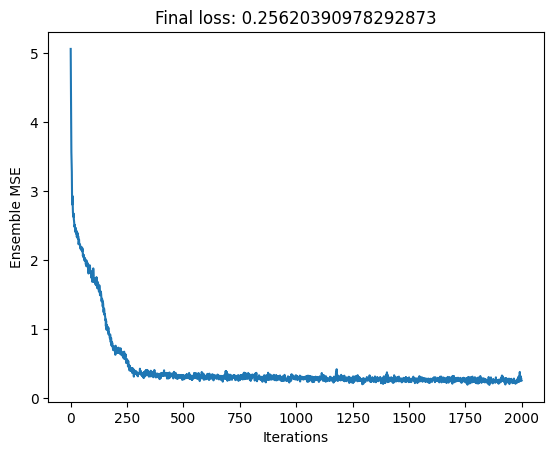

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(16.1418, 20), (1.4155, 20), (1.1637, 20), (1.5189, 20), (2.1133, 20), (1.3422, 20), (1.2632, 20), (1.471, 20), (1.3708, 20), (1.2747, 20), (1.2275, 20), (1.1858, 20), (1.2004, 20), (1.2546, 20), (1.3605, 20), (1.2681, 20), (1.2385, 20), (1.3891, 20), (1.1086, 20), (1.2814, 20), (1.52

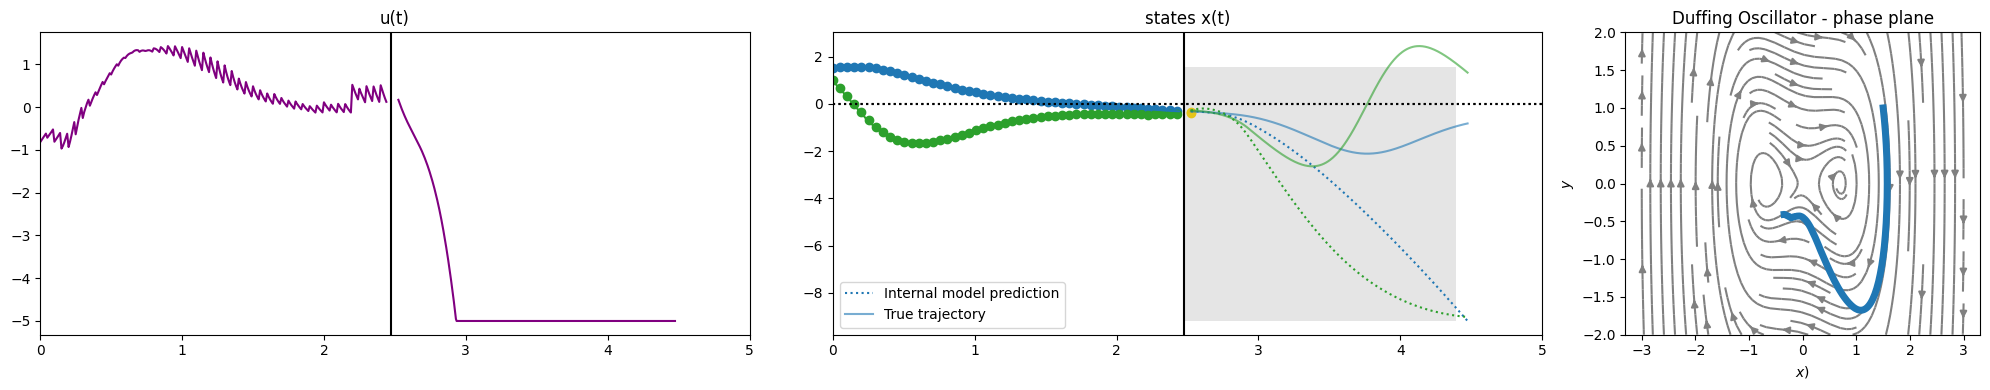

Traj. opt. times:  [(1.2866, 20), (1.2098, 20), (1.1031, 20), (1.3566, 20), (1.077, 20), (1.0112, 20), (1.0263, 20), (1.0918, 20), (1.1016, 20), (1.5456, 20), (1.3555, 20), (1.4237, 20), (1.4422, 20), (1.274, 20), (1.2575, 20), (1.2926, 20), (1.2354, 20), (1.1109, 20), (1.1991, 20), (1.255, 20), (1.1916, 20), (1.0682, 20), (1.2828, 20), (1.1467, 20), (1.2394, 20), (1.0697, 20), (1.1594, 20), (1.0421, 20), (1.0973, 20), (1.1988, 20), (1.1436, 20), (1.1262, 20), (1.0299, 20), (1.239, 20), (1.2265, 20), (1.1155, 20), (1.1254, 20), (1.147, 20), (1.4022, 20), (1.1568, 20), (1.165, 20), (1.3748, 20), (1.1736, 20), (1.1132, 20), (1.3508, 20), (1.3963, 20), (1.1616, 20), (1.1123, 20), (1.1331, 20), (1.14, 20)]


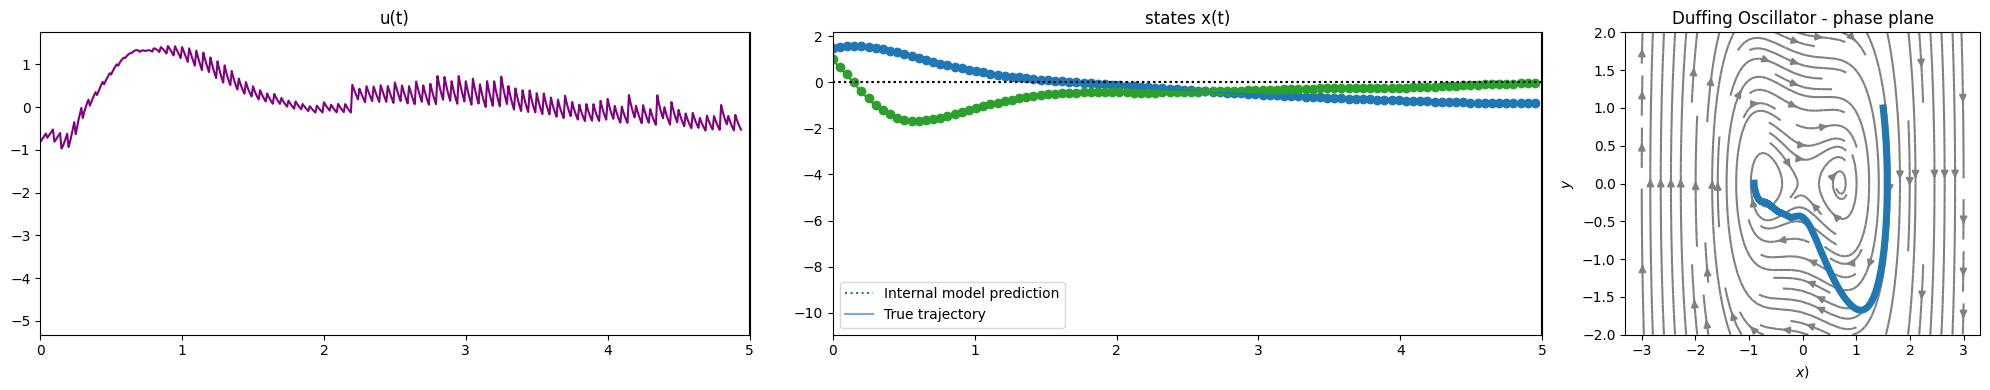

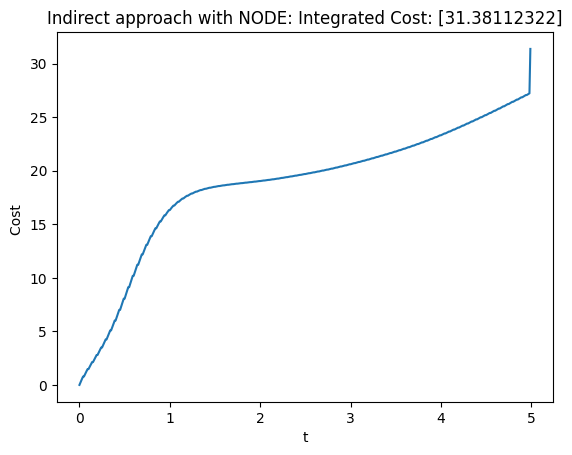

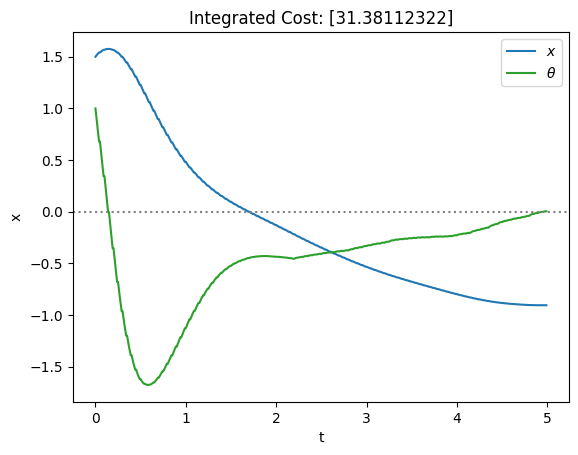

old data:  1 (1, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  2 (2, 100, 2)
Starting trial 2/10
5 (5, 2, 100, 2)


100%|██████████| 2000/2000 [02:40<00:00, 12.46it/s, loss=0.0277]


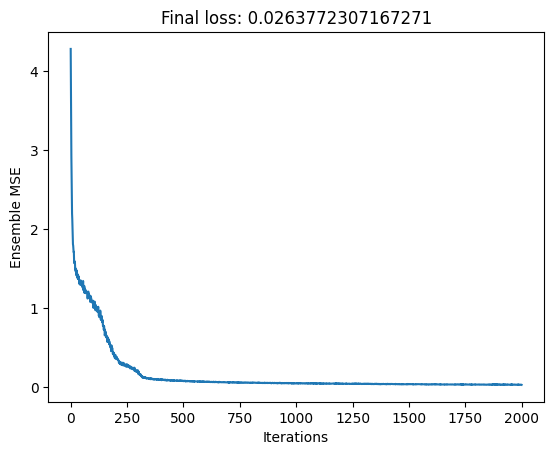

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(16.589, 20), (1.3582, 20), (1.1604, 20), (1.1892, 20), (1.1709, 20), (1.055, 20), (1.1872, 20), (1.0729, 20), (1.0671, 20), (1.0398, 20), (0.9917, 20), (0.985, 20), (0.8944, 20), (0.755, 15), (0.7671, 18), (0.8253, 17), (0.6942, 16), (0.7346, 15), (0.8465, 20), (0.8744, 19), (0.9246,

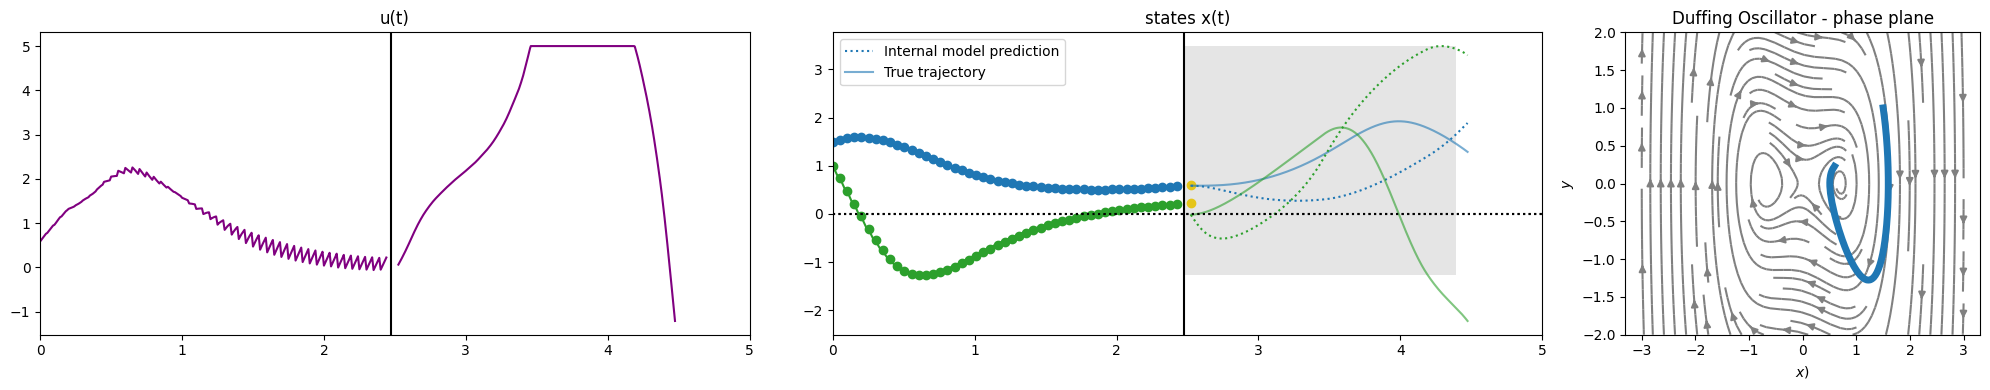

Traj. opt. times:  [(1.417, 20), (1.4327, 20), (1.301, 20), (0.9914, 20), (1.0571, 20), (1.0604, 20), (1.1623, 20), (1.3261, 20), (1.2193, 20), (1.1797, 20), (1.2111, 20), (1.4151, 20), (1.1179, 18), (1.0701, 18), (1.1125, 20), (1.0797, 17), (1.1738, 20), (0.9566, 17), (1.1566, 20), (0.9551, 20), (0.9456, 20), (1.0663, 20), (1.0838, 20), (1.0318, 18), (1.1051, 20), (1.2337, 20), (1.0309, 20), (1.266, 20), (0.8616, 16), (1.0792, 20), (1.2115, 20), (1.2142, 20), (0.9195, 16), (1.0763, 16), (1.0928, 20), (0.9886, 20), (1.2985, 20), (1.4328, 20), (1.3941, 20), (0.8536, 16), (1.1869, 20), (1.3105, 19), (0.9709, 18), (0.9314, 17), (1.1491, 20), (1.1217, 19), (1.1502, 20), (1.2499, 20), (1.3052, 20), (1.1937, 20)]


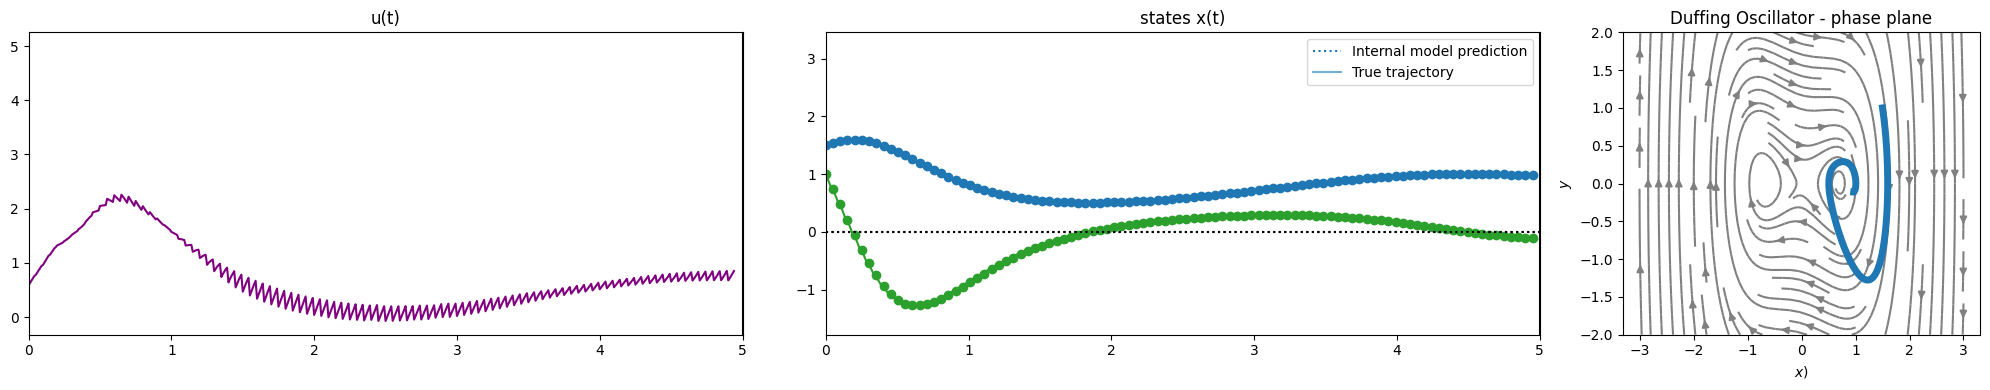

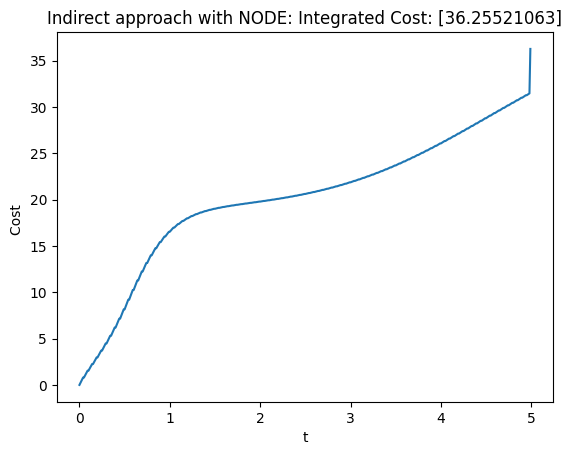

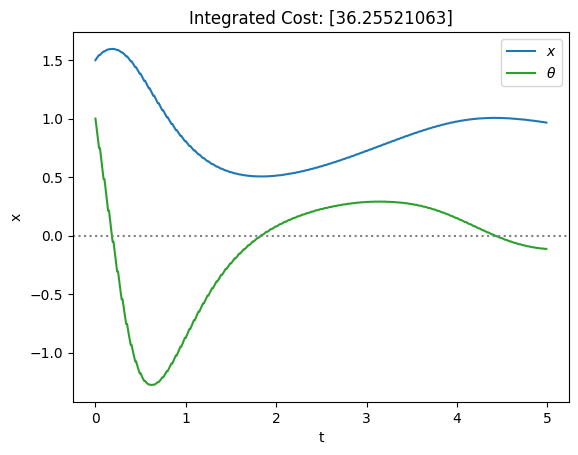

old data:  2 (2, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  3 (3, 100, 2)
Starting trial 3/10
5 (5, 3, 100, 2)


100%|██████████| 2000/2000 [03:32<00:00,  9.42it/s, loss=0.0988]


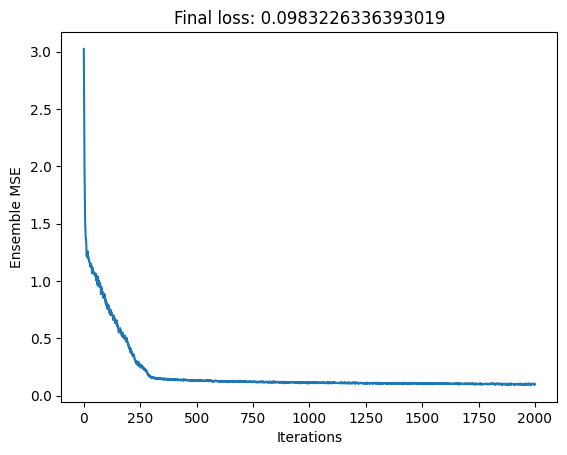

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(19.503, 20), (1.5539, 20), (1.7609, 20), (1.7373, 20), (2.0732, 20), (2.0537, 20), (1.6804, 20), (1.7429, 20), (1.7257, 20), (1.6063, 20), (2.0134, 20), (1.5639, 20), (1.9427, 20), (1.739, 20), (1.3753, 20), (1.4537, 20), (2.0874, 20), (1.5258, 20), (1.2297, 20), (1.3924, 20), (1.710

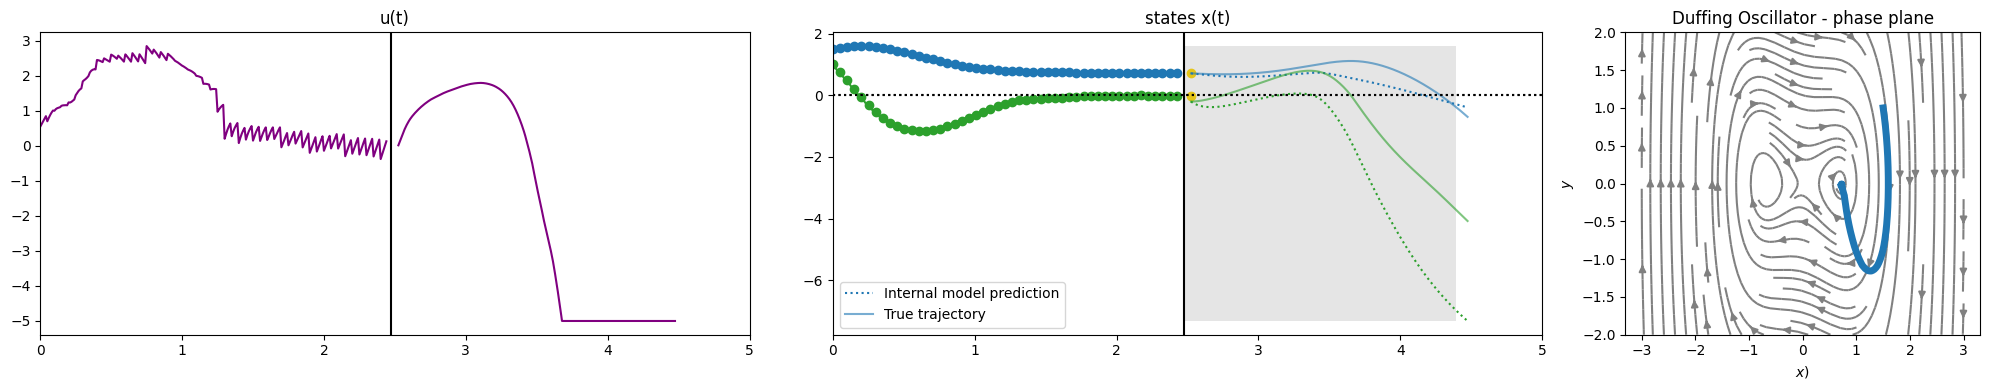

Traj. opt. times:  [(1.4937, 20), (1.3125, 20), (1.3328, 20), (1.1355, 20), (1.0956, 20), (1.1638, 20), (1.3426, 20), (1.1624, 20), (1.1278, 20), (1.0538, 20), (1.2013, 20), (1.0613, 20), (1.0377, 20), (1.2248, 20), (1.5218, 20), (1.1864, 20), (1.246, 20), (1.2036, 20), (1.2923, 20), (1.2175, 20), (1.411, 20), (1.5655, 20), (1.3674, 20), (1.5522, 20), (1.3036, 20), (1.3851, 20), (1.2689, 20), (1.1952, 20), (1.4696, 20), (1.216, 20), (1.3696, 20), (1.6599, 20), (1.5392, 20), (1.3112, 20), (1.1572, 20), (1.2752, 20), (1.0989, 20), (1.1424, 20), (1.1897, 20), (1.3052, 20), (1.284, 20), (1.2728, 20), (1.4448, 20), (1.4233, 20), (1.2361, 20), (1.5957, 20), (1.2988, 20), (1.2664, 20), (1.3484, 20), (1.234, 20)]


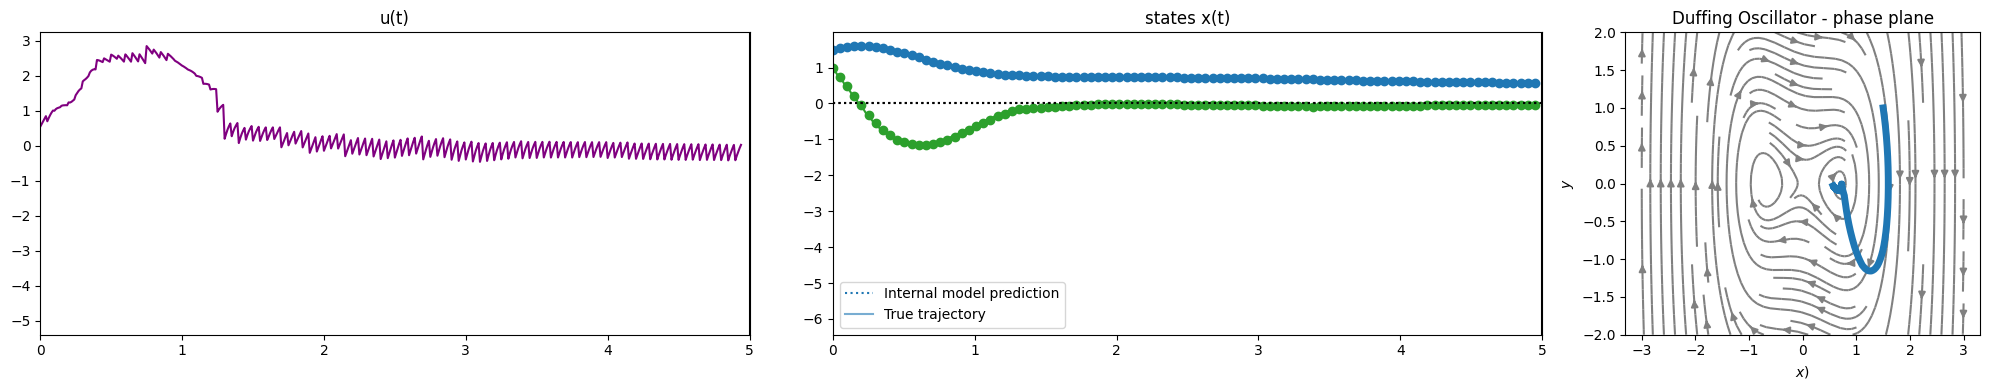

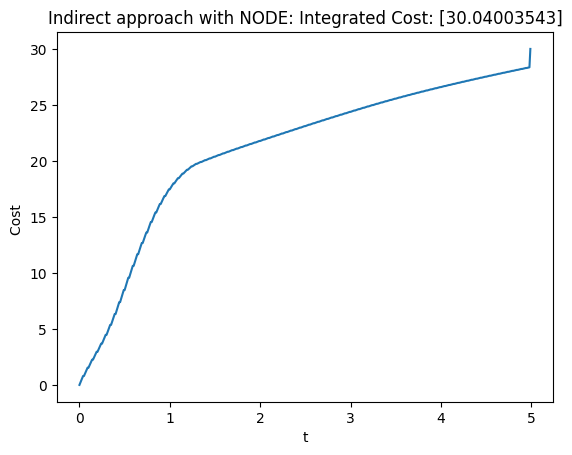

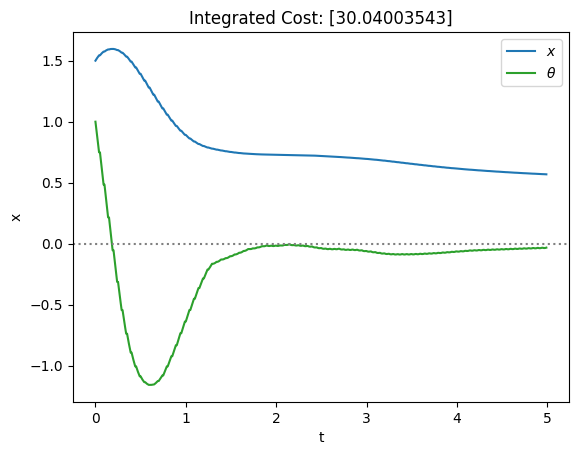

old data:  3 (3, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  4 (4, 100, 2)
Starting trial 4/10
5 (5, 4, 100, 2)


100%|██████████| 2000/2000 [04:33<00:00,  7.31it/s, loss=0.0948]


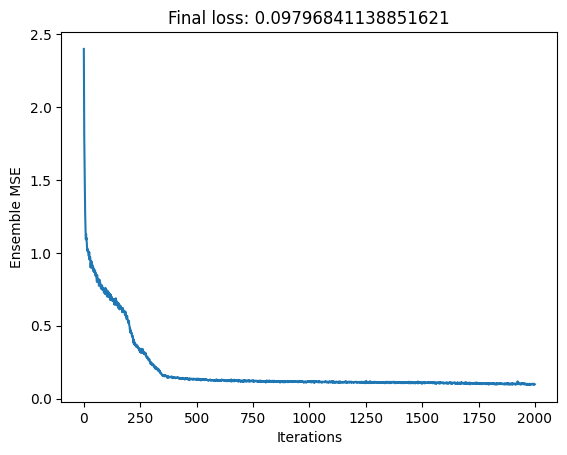

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(20.618, 20), (1.3424, 20), (1.2267, 20), (1.4287, 20), (1.808, 20), (1.7242, 20), (1.5373, 20), (1.9304, 20), (1.878, 20), (1.8609, 20), (1.9906, 20), (2.1145, 20), (1.8326, 20), (1.396, 20), (1.5306, 20), (1.6044, 20), (1.666, 20), (1.3641, 20), (1.4548, 20), (1.4471, 20), (1.4183, 

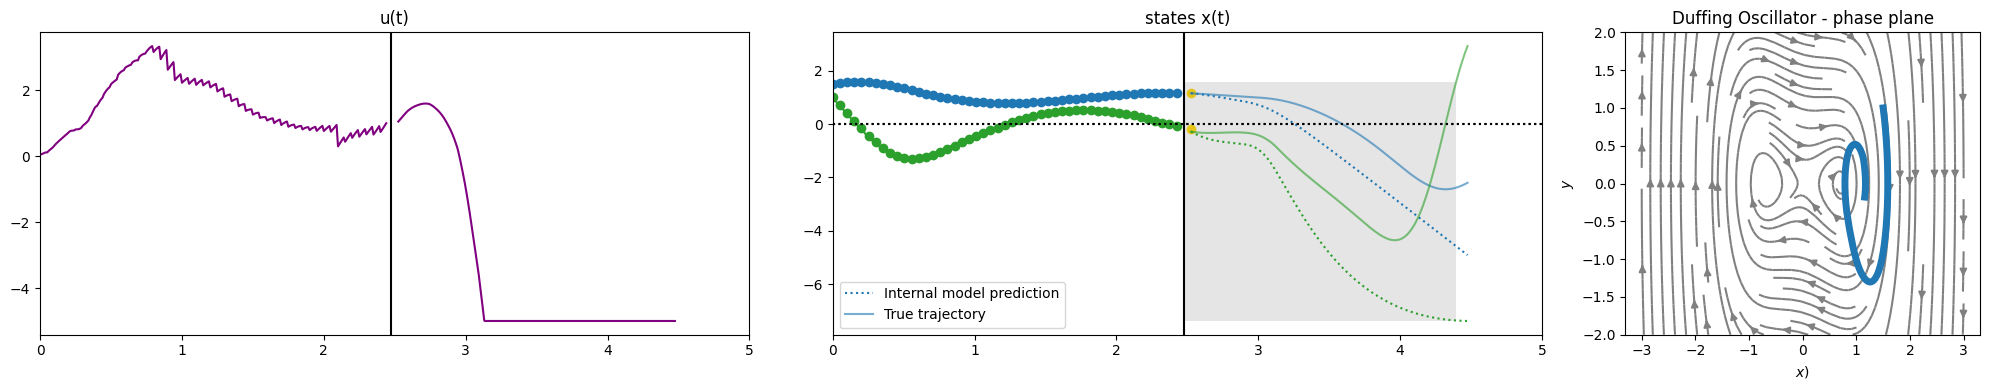

Traj. opt. times:  [(1.3622, 20), (1.3039, 20), (1.1367, 20), (1.4381, 20), (1.0658, 20), (1.6043, 20), (1.4945, 20), (1.5887, 20), (1.4623, 20), (1.6108, 20), (1.6246, 20), (1.4386, 20), (1.2448, 20), (1.4177, 20), (1.6044, 20), (1.4607, 20), (1.5256, 20), (1.7442, 20), (1.5696, 20), (1.557, 20), (1.4609, 20), (1.5171, 20), (1.4667, 20), (1.3424, 20), (1.4043, 20), (1.2382, 20), (1.5425, 20), (1.4977, 20), (1.867, 20), (1.7034, 20), (1.9515, 20), (1.6092, 20), (1.6816, 20), (1.5104, 20), (1.2859, 20), (1.3182, 20), (1.4447, 20), (1.7206, 20), (1.4427, 20), (1.7153, 20), (1.7553, 20), (1.614, 20), (1.5322, 20), (1.3918, 20), (1.4728, 20), (1.412, 20), (1.4867, 20), (1.0953, 20), (1.3108, 20), (1.4382, 20)]


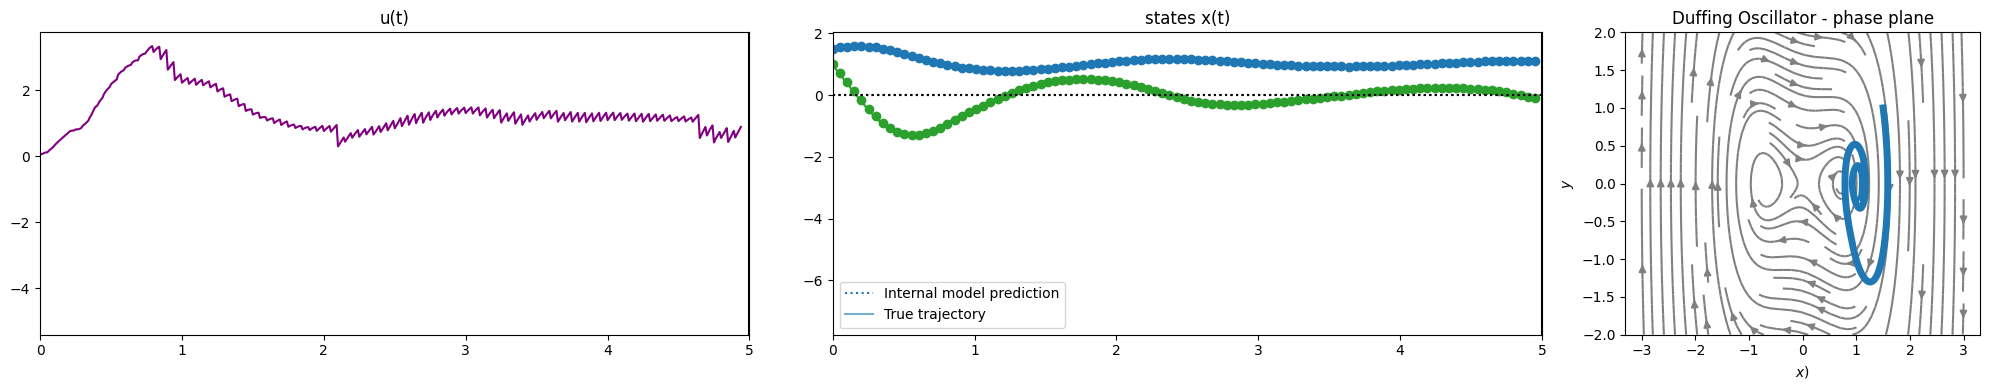

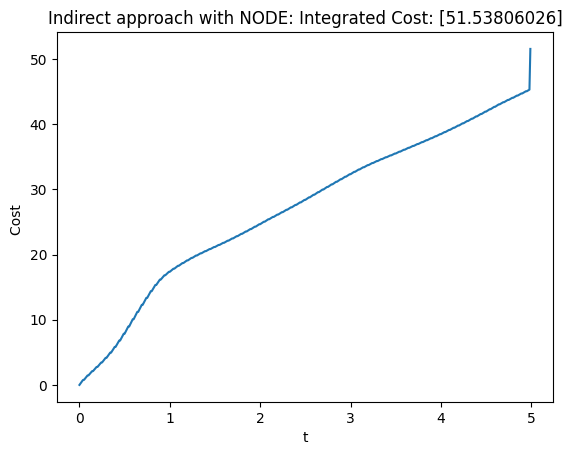

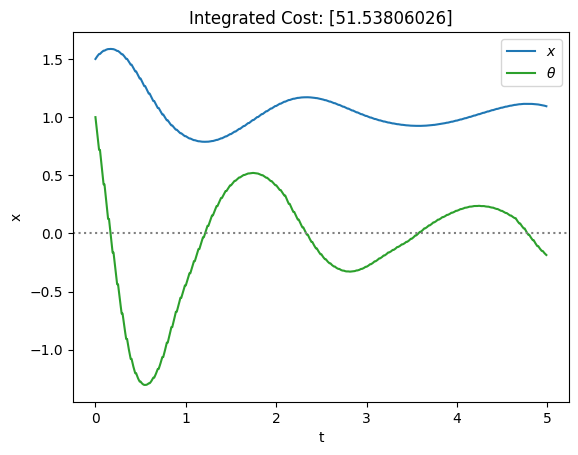

old data:  4 (4, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  5 (5, 100, 2)
Starting trial 5/10
5 (5, 5, 100, 2)


100%|██████████| 2000/2000 [05:18<00:00,  6.29it/s, loss=0.0877]


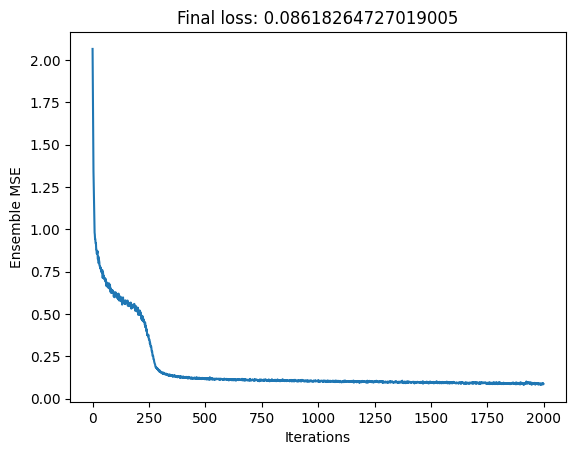

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(17.2433, 20), (1.7473, 20), (1.3969, 20), (1.4798, 20), (1.4127, 20), (1.1736, 20), (1.1963, 20), (1.4284, 20), (1.306, 20), (1.4362, 20), (1.3862, 20), (1.4325, 20), (1.2447, 20), (1.4421, 20), (1.5038, 20), (1.1718, 20), (1.5014, 20), (1.2038, 20), (1.4698, 20), (1.5841, 20), (1.10

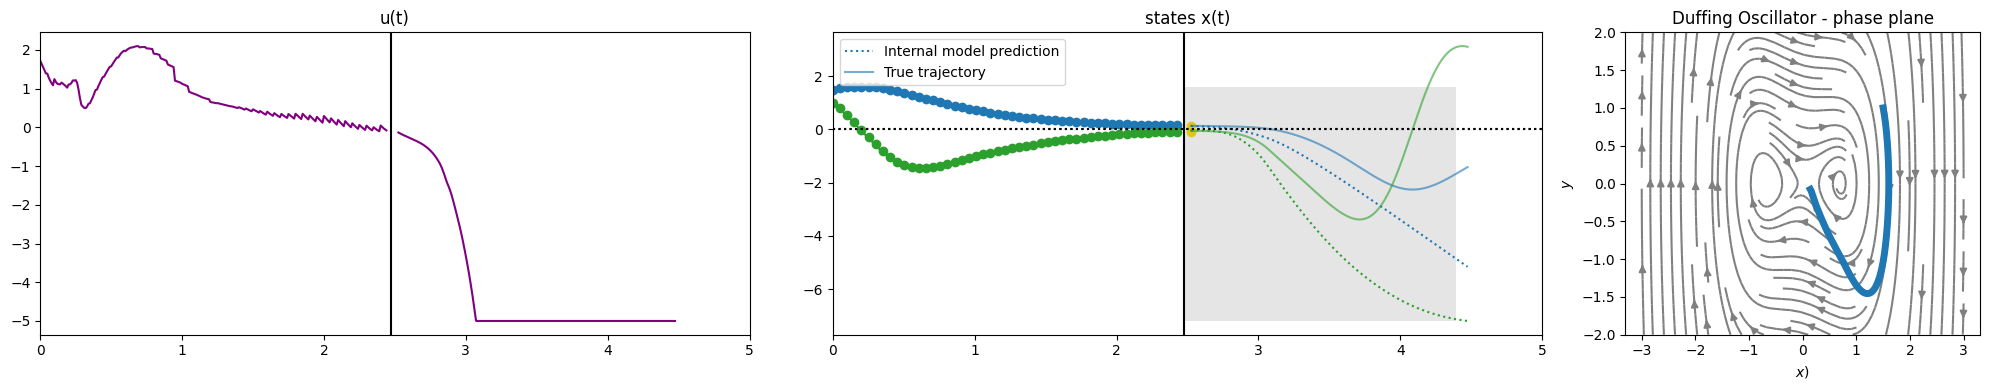

Traj. opt. times:  [(1.0524, 20), (0.9256, 20), (1.1686, 20), (1.1174, 20), (1.3114, 20), (1.5389, 20), (1.3469, 20), (0.9231, 20), (0.9573, 20), (1.0928, 20), (0.9234, 20), (0.8869, 20), (1.0758, 20), (1.0482, 20), (1.0553, 20), (1.0516, 20), (1.1564, 20), (1.1862, 20), (1.1618, 20), (1.2969, 20), (1.0683, 20), (1.3349, 20), (1.2247, 20), (1.4251, 20), (1.4548, 20), (1.3838, 20), (1.3024, 20), (1.2614, 20), (1.167, 20), (1.2178, 20), (1.304, 20), (1.1888, 20), (1.1872, 20), (1.3496, 20), (1.5188, 20), (1.365, 20), (1.2548, 20), (1.3716, 20), (1.3633, 20), (1.1586, 20), (1.1038, 20), (1.0168, 20), (0.9648, 20), (1.1089, 20), (1.1653, 20), (1.0937, 20), (1.1013, 20), (1.1145, 20), (1.1348, 20), (1.4146, 20)]


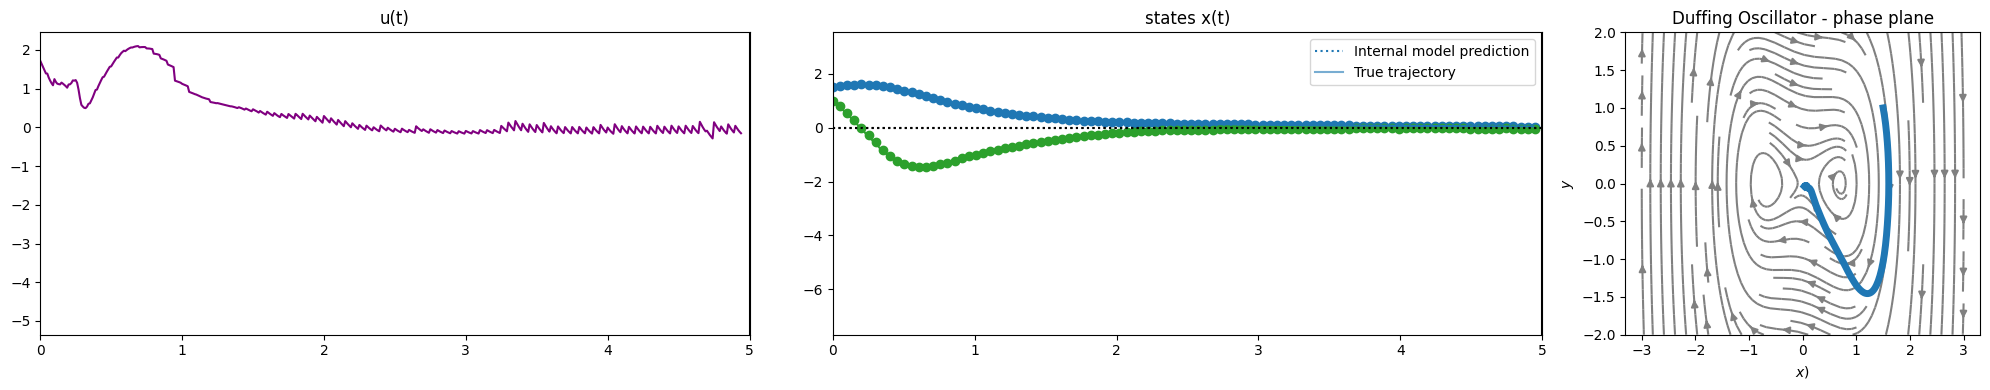

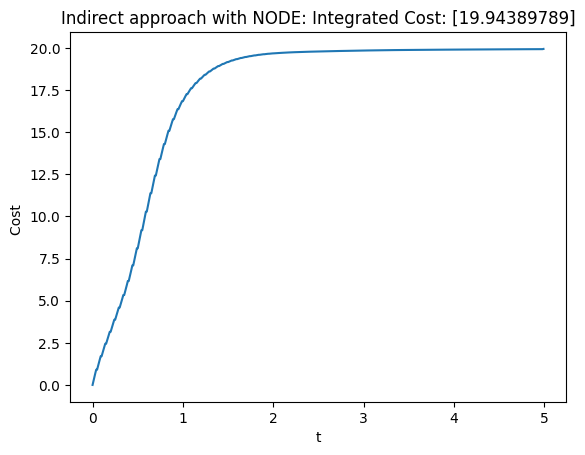

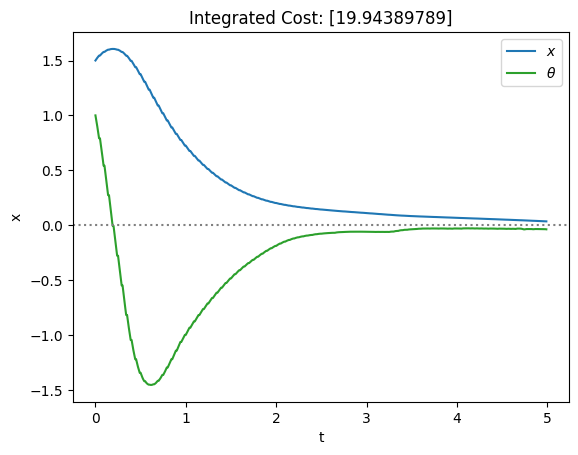

old data:  5 (5, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  6 (6, 100, 2)
Starting trial 6/10
5 (5, 6, 100, 2)


100%|██████████| 2000/2000 [05:50<00:00,  5.71it/s, loss=0.0855]


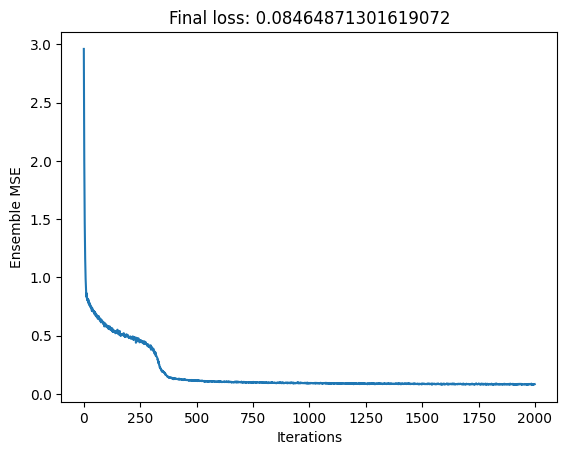

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(17.425, 20), (1.2005, 20), (1.2828, 20), (1.261, 20), (1.3101, 20), (1.3157, 20), (1.2992, 20), (1.3569, 20), (1.2264, 20), (1.4708, 20), (1.6593, 20), (1.4748, 20), (0.97, 20), (1.0637, 20), (1.2317, 20), (1.3352, 20), (1.3683, 20), (1.3834, 20), (1.3475, 20), (1.7605, 20), (1.468, 

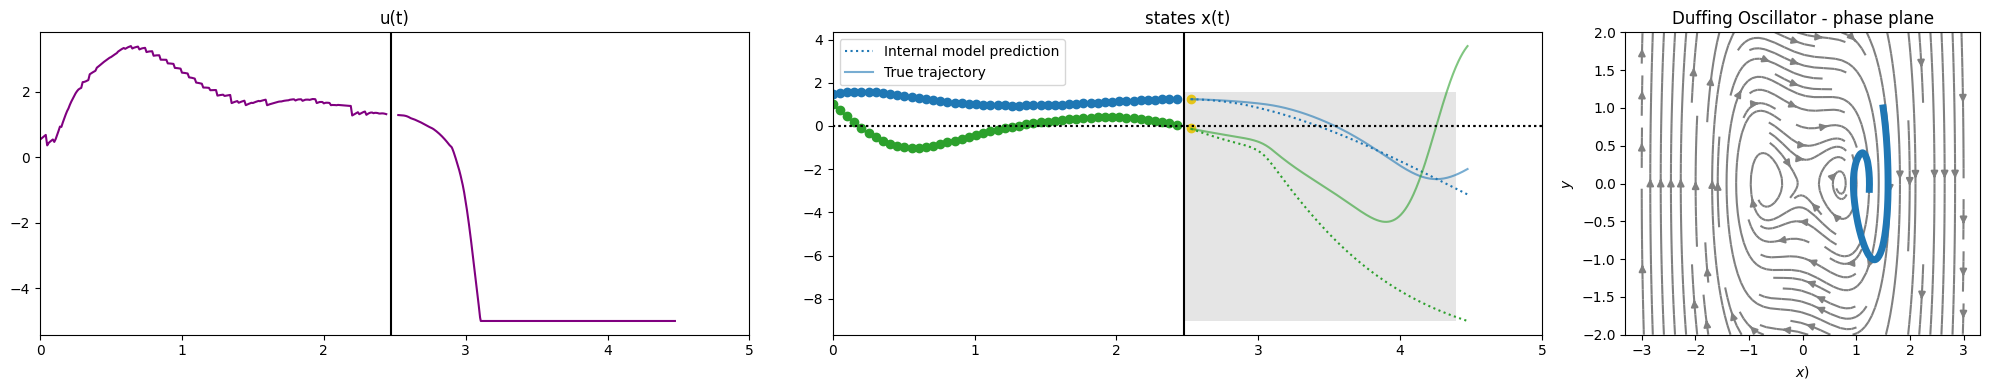

Traj. opt. times:  [(1.6975, 20), (1.8188, 20), (1.6055, 20), (1.388, 20), (1.3567, 20), (1.4602, 20), (1.4989, 20), (1.559, 20), (1.6684, 20), (1.4213, 20), (1.2879, 20), (1.7529, 20), (1.3207, 20), (1.1223, 20), (1.3201, 20), (1.1335, 20), (1.0571, 20), (1.2032, 20), (1.1444, 20), (1.2453, 20), (1.3865, 20), (1.1842, 20), (1.1573, 20), (1.314, 20), (1.4699, 20), (1.6992, 20), (1.4298, 20), (1.6448, 20), (1.7512, 20), (1.4951, 20), (1.5205, 20), (1.3546, 20), (1.5659, 20), (1.6228, 20), (1.4364, 20), (1.6545, 20), (1.5171, 20), (1.5725, 20), (1.6294, 20), (1.4848, 20), (1.4359, 20), (1.1377, 20), (1.1558, 20), (1.2204, 20), (1.087, 20), (1.3564, 20), (1.3063, 20), (1.1491, 20), (1.2535, 20), (1.2376, 20)]


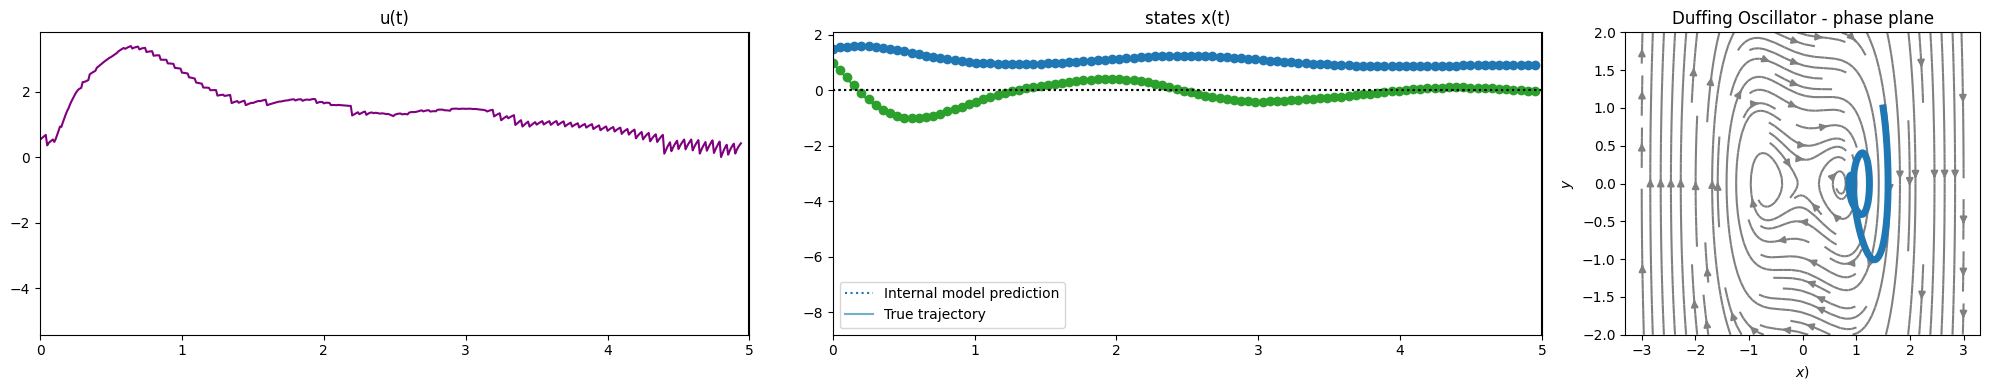

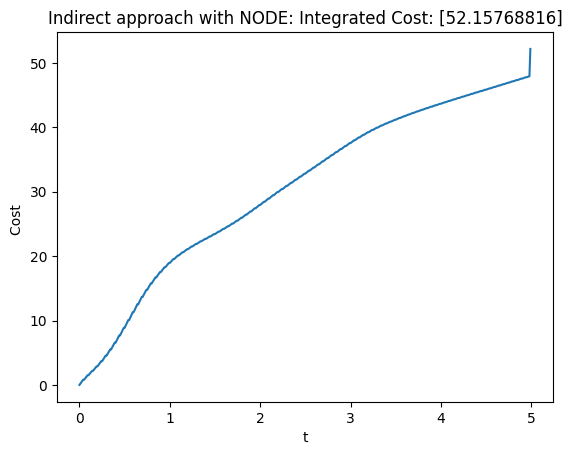

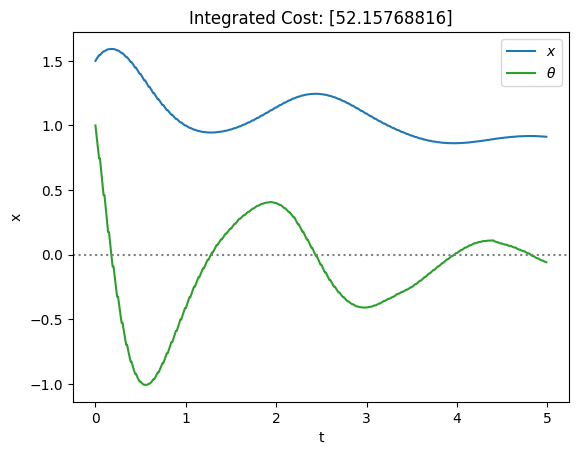

old data:  6 (6, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  7 (7, 100, 2)
Starting trial 7/10
5 (5, 7, 100, 2)


100%|██████████| 2000/2000 [06:42<00:00,  4.97it/s, loss=0.0775]


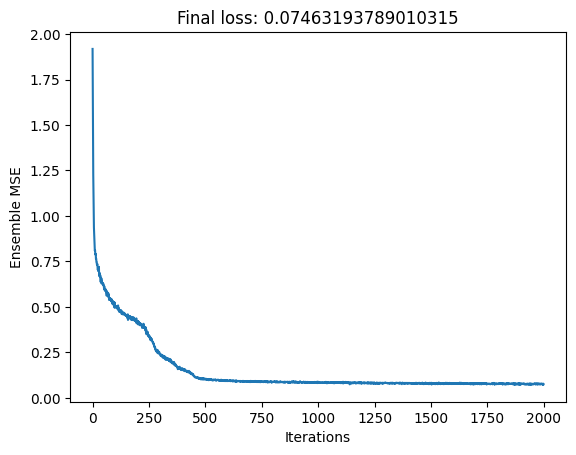

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(18.8414, 20), (1.6045, 20), (1.5323, 20), (1.4009, 20), (1.2348, 20), (1.2784, 20), (1.013, 20), (1.1307, 20), (1.0871, 20), (1.0933, 20), (1.2054, 20), (1.1078, 20), (0.9722, 20), (0.8648, 20), (0.8904, 20), (0.9471, 20), (1.0535, 20), (0.8545, 20), (0.8621, 20), (0.7862, 20), (0.82

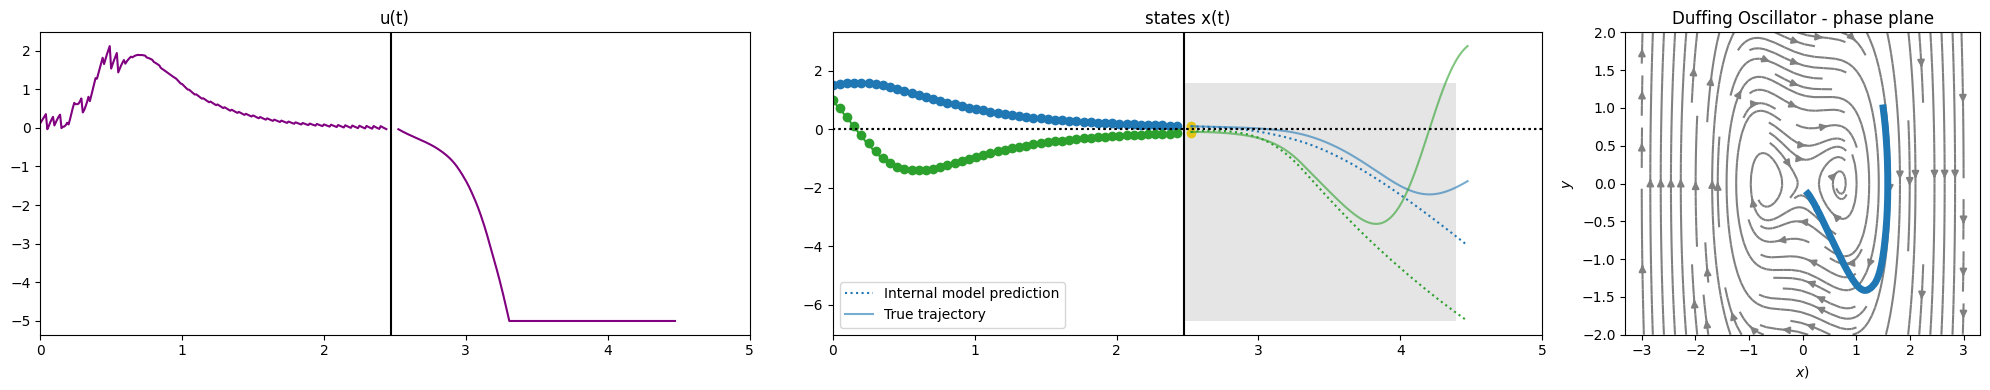

Traj. opt. times:  [(1.1011, 20), (0.952, 20), (0.8212, 20), (0.848, 20), (0.9411, 20), (0.8909, 20), (0.8661, 20), (0.8526, 20), (0.823, 20), (0.8944, 20), (1.2195, 20), (0.9375, 20), (0.8844, 20), (1.0859, 20), (1.0918, 20), (1.0273, 20), (1.0257, 20), (1.1201, 20), (1.0089, 20), (1.1481, 20), (1.0231, 20), (1.0988, 20), (1.0889, 20), (1.1698, 20), (1.0786, 20), (1.1481, 20), (1.0076, 20), (1.072, 20), (1.1182, 20), (1.1745, 20), (1.0777, 20), (1.0928, 20), (1.0976, 20), (1.0974, 20), (1.122, 20), (1.0846, 20), (1.16, 20), (1.09, 20), (1.0668, 20), (1.0488, 20), (1.0488, 20), (1.0516, 20), (1.1552, 20), (1.0455, 20), (1.0682, 20), (0.9795, 20), (0.9892, 20), (1.0412, 20), (1.0145, 20), (1.3798, 20)]


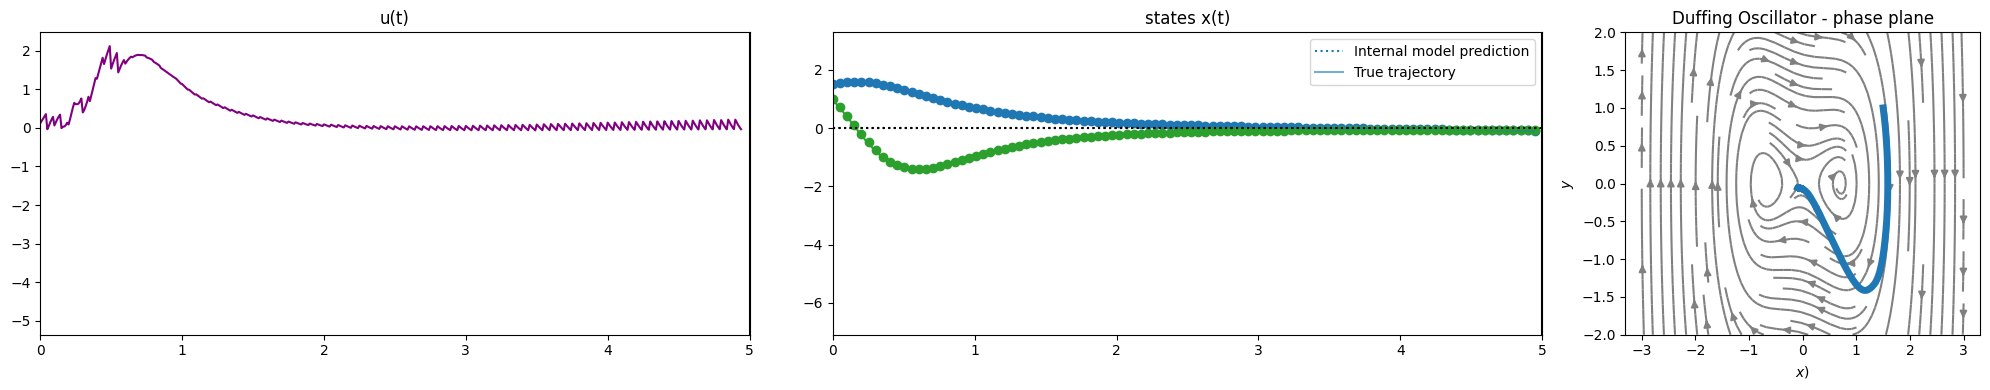

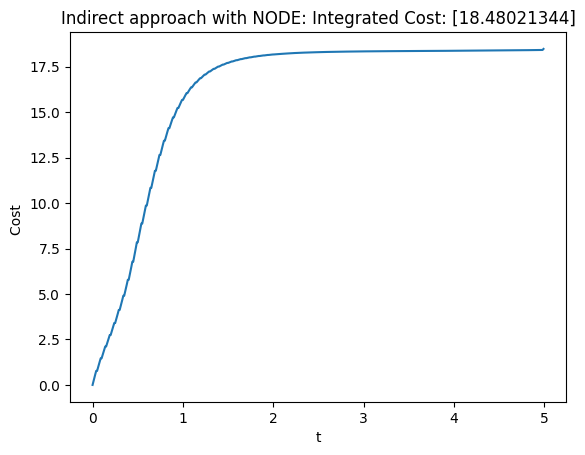

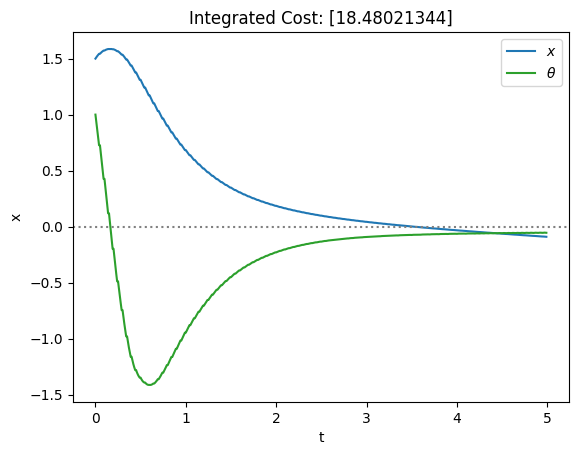

old data:  7 (7, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  8 (8, 100, 2)
Starting trial 8/10
5 (5, 8, 100, 2)


100%|██████████| 2000/2000 [07:10<00:00,  4.65it/s, loss=0.0704]


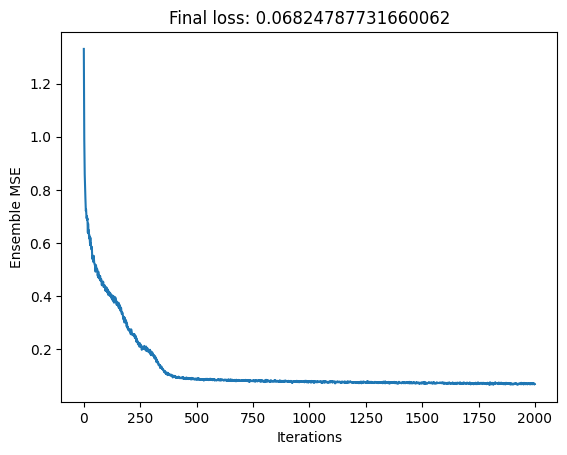

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(15.6994, 20), (1.2858, 20), (1.3668, 20), (1.4861, 20), (1.1506, 20), (1.0757, 20), (1.2966, 20), (1.1058, 20), (1.0102, 20), (1.0525, 20), (1.1884, 20), (1.0747, 20), (1.0554, 20), (0.7949, 20), (0.874, 20), (0.7797, 20), (0.7385, 20), (0.7309, 20), (0.7056, 18), (0.8955, 20), (0.81

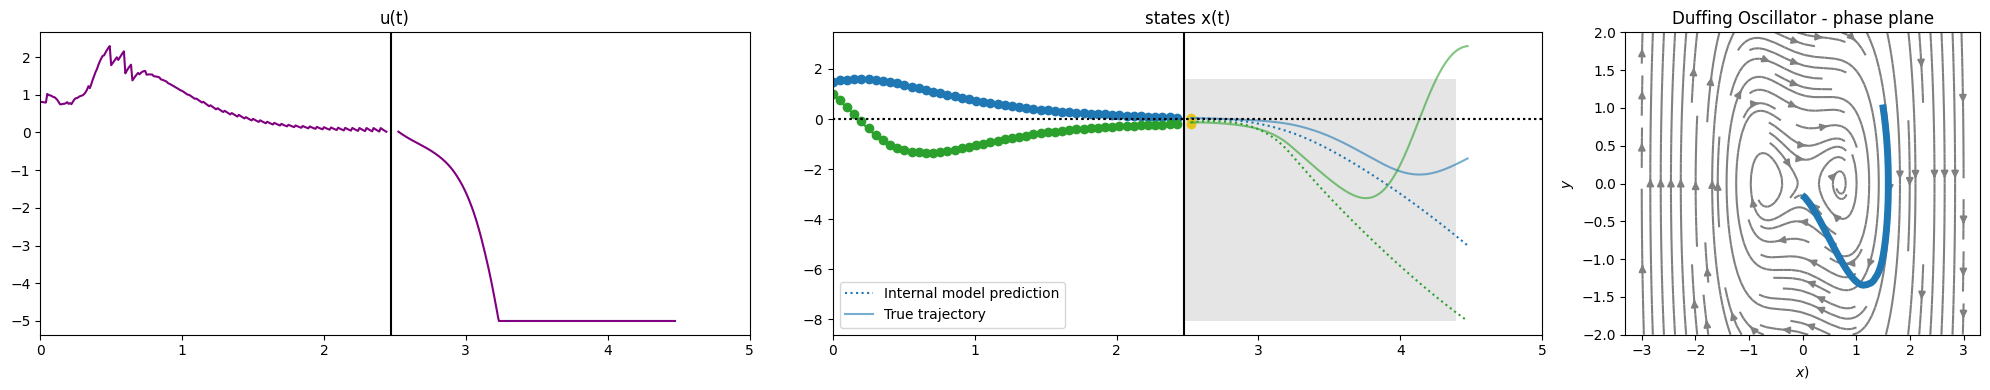

Traj. opt. times:  [(0.816, 20), (0.6726, 15), (0.8986, 17), (0.8858, 16), (0.8123, 16), (0.8473, 16), (0.8477, 16), (0.9151, 18), (0.8944, 16), (0.8317, 16), (0.8004, 16), (1.037, 20), (0.748, 16), (1.0849, 20), (1.0106, 20), (0.996, 20), (1.0899, 17), (0.814, 16), (0.9939, 18), (1.0614, 20), (1.1092, 20), (1.0073, 20), (1.099, 20), (0.9408, 20), (1.0064, 20), (0.9468, 19), (1.0367, 20), (1.0148, 20), (1.2141, 20), (1.0183, 20), (1.0156, 20), (1.1277, 20), (1.0265, 20), (0.9569, 20), (0.9323, 20), (0.9552, 20), (0.9317, 20), (0.9612, 20), (0.9259, 20), (0.9438, 20), (0.924, 20), (0.947, 20), (0.9343, 20), (0.9372, 20), (0.9282, 20), (0.9326, 20), (0.9212, 20), (0.942, 20), (0.9476, 20), (0.9345, 20)]


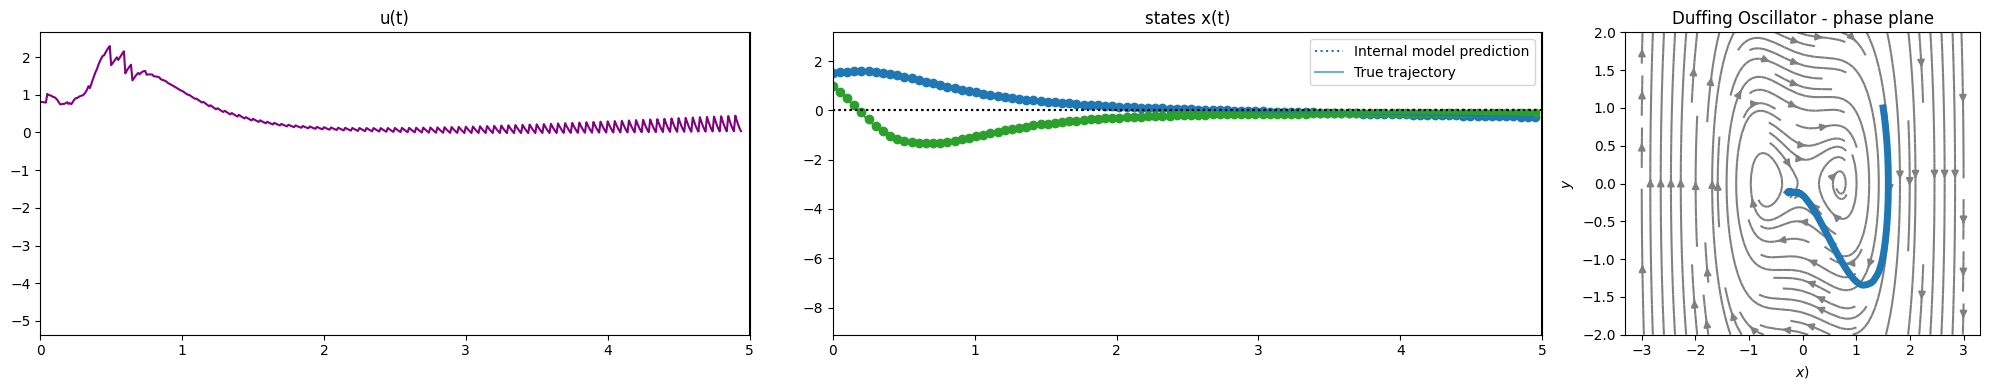

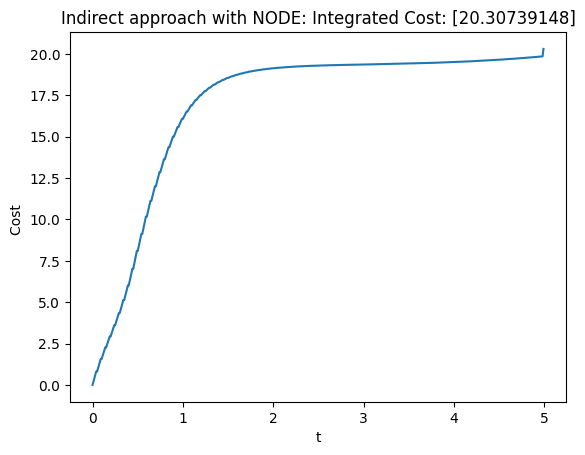

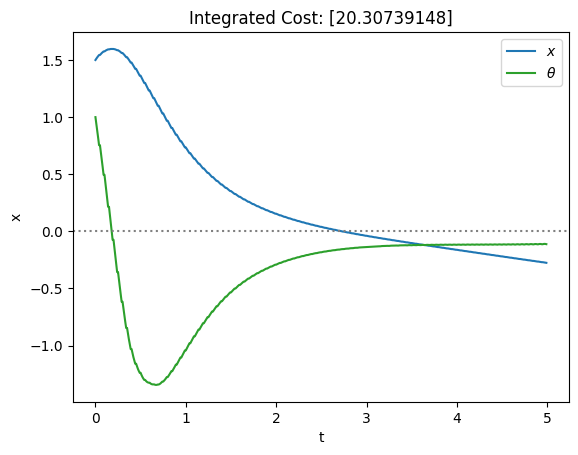

old data:  8 (8, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  9 (9, 100, 2)
Starting trial 9/10
5 (5, 9, 100, 2)


100%|██████████| 2000/2000 [07:47<00:00,  4.28it/s, loss=0.0667]


Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(16.1505, 20), (1.3178, 20), (1.2197, 20), (1.1959, 20), (1.145, 20), (1.0738, 20), (1.1424, 20), (1.0992, 20), (1.0516, 20), (1.1806, 20), (1.088, 20), (1.0985, 20), (1.1188, 20), (1.0564, 20), (1.2632, 20), (1.149, 20), (1.1782, 20), (1.1237, 20), (1.1692, 20), (1.3419, 20), (1.1109

Traj. opt. times:  [(1.2795, 20), (1.1152, 20), (1.1699, 20), (1.1301, 20), (0.9799, 20), (0.9453, 20), (1.0247, 20), (1.1066, 20), (1.0051, 20), (1.0099, 20), (1.1898, 20), (1.2534, 20), (1.0306, 20), (1.0572, 20), (1.0126, 20), (1.1138, 20), (1.0008, 20), (1.0109, 20), (1.0131, 20), (1.1225, 20), (1.1007, 20), (1.0427, 20), (1.0293, 20), (1.1144, 20), (1.1104, 20), (1.0164, 20), (0.9981, 20), (1.0762, 20), (1.0933, 20), (1.0136, 20), (1.0937, 20), (1.0461, 20), (1.0165, 20), (1.2132, 20), (0.9563, 19), (1.0853, 20), (1.0236, 19), (0.963, 19), (1.1123, 20), (1.0142, 20), (1.0913, 20), (1.0056, 20), (1.156, 20), (1.0179, 20), (1.0355, 20), (0.8421, 17), (0.7857, 17), (0.8427, 17), (0.9375, 17), (0.9203, 18)]


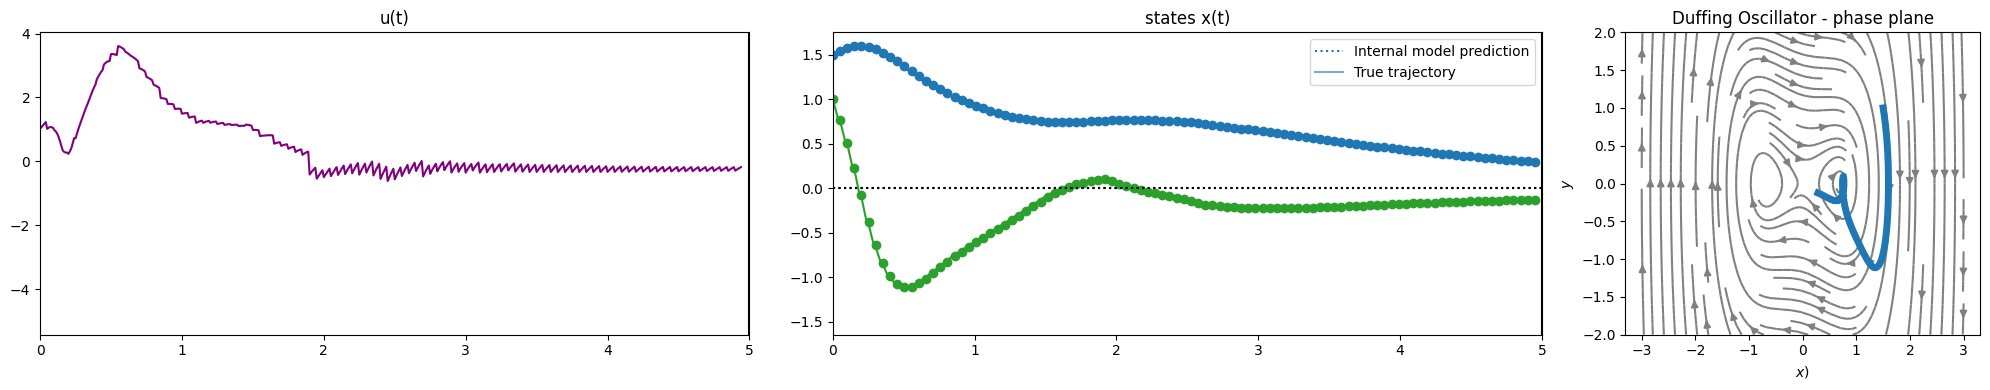

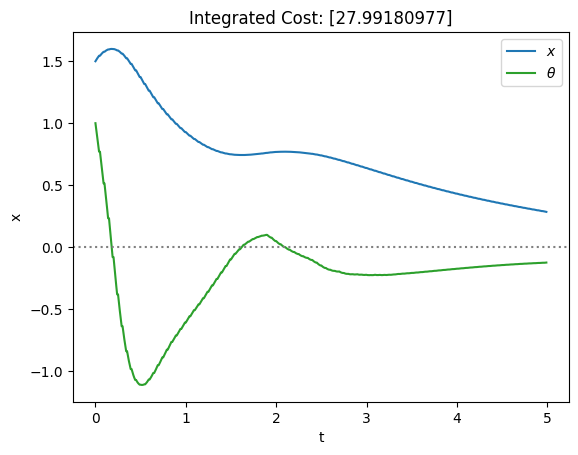

old data:  9 (9, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  10 (10, 100, 2)
Starting trial 10/10
5 (5, 10, 100, 2)


100%|██████████| 2000/2000 [08:39<00:00,  3.85it/s, loss=0.0698]


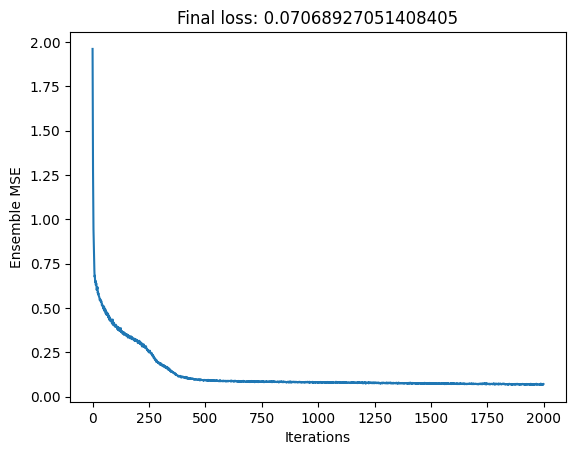

Initial optimization (iteration 0) not succesfull, continuing.
Initial optimization (iteration 1) not succesfull, continuing.
Initial optimization (iteration 2) not succesfull, continuing.
Initial optimization (iteration 3) not succesfull, continuing.
Initial optimization (iteration 4) not succesfull, continuing.
Initial optimization (iteration 5) not succesfull, continuing.
Initial optimization (iteration 6) not succesfull, continuing.
Initial optimization (iteration 7) not succesfull, continuing.
Initial optimization (iteration 8) not succesfull, continuing.
Initial optimization (iteration 9) not succesfull, continuing.
Initial optimization over, starting trial with initial solution.
Traj. opt. times:  [(15.1123, 20), (1.4331, 20), (1.5341, 20), (1.2261, 20), (1.2592, 20), (1.0114, 20), (1.0562, 20), (1.0749, 20), (0.9805, 20), (0.9319, 20), (0.9954, 20), (0.842, 20), (0.8844, 20), (0.8946, 20), (0.8117, 20), (0.7927, 20), (0.7189, 15), (0.6882, 17), (0.7228, 18), (0.7299, 19), (0.61

Traj. opt. times:  [(1.0657, 20), (1.0168, 20), (1.2164, 20), (1.0416, 20), (1.0953, 20), (1.0182, 20), (1.0294, 20), (1.0251, 20), (1.0304, 20), (0.9474, 20), (0.926, 20), (0.9246, 20), (0.9969, 20), (0.9941, 20), (1.0276, 20), (1.001, 20), (1.0216, 20), (1.0585, 20), (0.9845, 20), (0.9366, 20), (0.9796, 20), (1.1036, 20), (1.0745, 20), (1.0431, 20), (1.0067, 20), (1.0907, 20), (1.0181, 20), (0.9382, 20), (0.9563, 20), (0.9611, 20), (1.0072, 20), (1.0163, 20), (1.1108, 20), (1.0166, 20), (1.0516, 20), (1.1038, 20), (1.1501, 20), (1.0192, 20), (1.0951, 20), (1.0116, 20), (1.0024, 20), (0.9622, 20), (0.9295, 20), (0.9545, 20), (1.0717, 20), (0.9983, 20), (1.0172, 20), (1.065, 20), (1.0282, 20), (0.996, 20)]


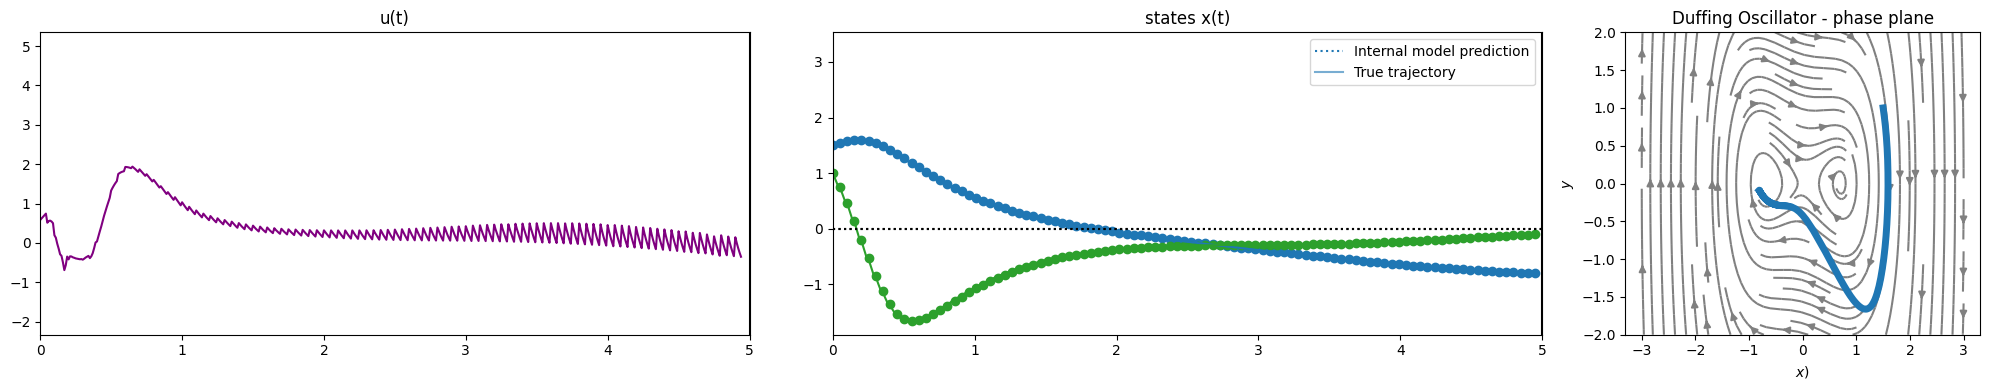

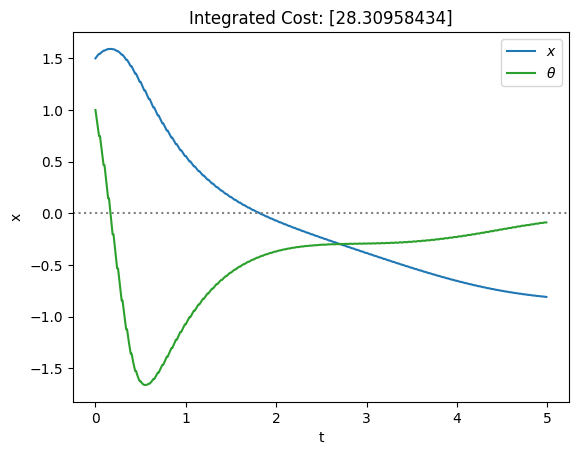

old data:  10 (10, 100, 2)
new trial:  1 (1, 100, 2)
Combiend data:  11 (11, 100, 2)


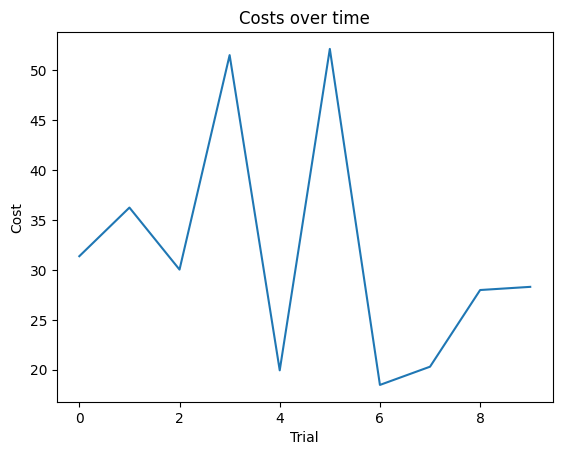

In [8]:
trial_costs = []
for i in range(num_trials):
    print(f'Starting trial {i+1}/{num_trials}')
    # train deep NODE ensemble 
    key, subkey = jr.split(key)
    opt_ensemble_node = train_network(data, subkey)

    # run trial
    key, subkey = jr.split(key)
    ts, ts_dense, X, Y, U, R = run_single_trial(opt_ensemble_node=opt_ensemble_node, key=subkey)
    final_cost = R[-1]
    trial_costs.append(final_cost)

    # augment dataset
    new_trial_dataset = DiffEqDataset(ts[None,...], Y[None,...], U[None,...], ts_dense=ts_dense[None,...], standardize_at_initialisation=False)
    ## to do: standardize the theta value here.
    ## 2nd to do: look into if the model gets better with data standardization.
    print('old data: ', data.n, data.ys.shape)
    print('new trial: ', new_trial_dataset.n, new_trial_dataset.ys.shape)
    data = data + new_trial_dataset
    print('Combiend data: ',data.n, data.ys.shape)

trial_costs = jnp.array(trial_costs)
plt.figure()
plt.title('Costs over time')
plt.xlabel('Trial')
plt.ylabel('Cost')
plt.plot(jnp.arange(trial_costs.shape[0]), trial_costs)
plt.show()


In [9]:
trial_costs

Array([[31.38112322],
       [36.25521063],
       [30.04003543],
       [51.53806026],
       [19.94389789],
       [52.15768816],
       [18.48021344],
       [20.30739148],
       [27.99180977],
       [28.30958434]], dtype=float64)

In [10]:
# plt.figure()
# plt.title('Costs over time')
# plt.xlabel('Trial')
# plt.ylabel('Cost')
# plt.plot(jnp.arange(trial_costs.shape[0]), trial_costs_det, label='SQP-E=1')
# plt.plot(jnp.arange(trial_costs.shape[0]), trial_costs_sqp_ensemble, label='SQP-E=5')
# plt.plot(jnp.arange(trial_costs.shape[0]), trial_costs_pmp_ensemble, label='PMP-E=1')
# plt.plot(jnp.arange(trial_costs.shape[0]), trial_costs_pmp_ensemble5, label='PMP-E=5 (Mean posterior)')
# plt.plot(jnp.arange(trial_costs.shape[0]), trial_costs_pmp_ensemble5_mean_hamil, label='PMP-E=5 (Mean Hamiltonian)')


# plt.scatter(jnp.arange(trial_costs.shape[0]), trial_costs_det)
# plt.scatter(jnp.arange(trial_costs.shape[0]), trial_costs_sqp_ensemble)
# plt.scatter(jnp.arange(trial_costs.shape[0]), trial_costs_pmp_ensemble)
# plt.scatter(jnp.arange(trial_costs.shape[0]), trial_costs_pmp_ensemble5)
# plt.scatter(jnp.arange(trial_costs.shape[0]), trial_costs_pmp_ensemble5_mean_hamil)



# plt.legend()
# plt.show()


In [11]:
trial_costs

Array([[31.38112322],
       [36.25521063],
       [30.04003543],
       [51.53806026],
       [19.94389789],
       [52.15768816],
       [18.48021344],
       [20.30739148],
       [27.99180977],
       [28.30958434]], dtype=float64)

### Colors
Method 1: Blue (#1f77b4, a muted MATLAB-like blue).

Method 2: Red (#d62728, a subdued red).

Method 3: Green (#2ca02c, a soft green).
alpha 0.2 for confidence intervals.


##  Linwidth
linewidth=1.5 o

## background lines:
plt.grid(True, linestyle='--', alpha=0.5)


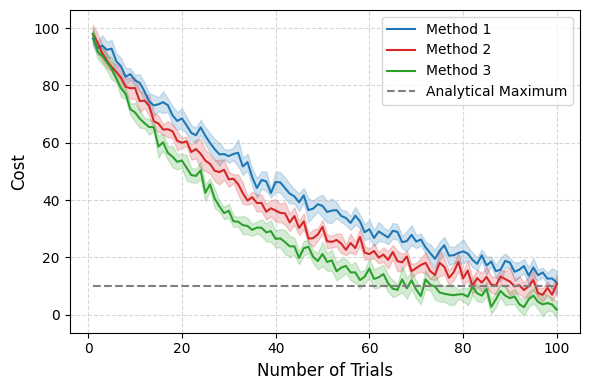

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Dummy data
trials = np.arange(1, 101)
methods = {
    "Method 1": np.exp(-trials/50) * 100 + np.random.normal(0, 5, (10, 100)),
    "Method 2": np.exp(-trials/40) * 100 + np.random.normal(0, 5, (10, 100)),
    "Method 3": np.exp(-trials/30) * 100 + np.random.normal(0, 5, (10, 100))
}
analytical_max = np.full(100, 10)  # Example baseline

# Colors
colors = ["#1f77b4", "#d62728", "#2ca02c"]

# Plot
plt.figure(figsize=(6, 4))
for i, (name, data) in enumerate(methods.items()):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    ci = 1.96 * std / np.sqrt(10)  # 95% CI
    plt.plot(trials, mean, label=name, color=colors[i], linewidth=1.5)
    plt.fill_between(trials, mean - ci, mean + ci, color=colors[i], alpha=0.2)

plt.plot(trials, analytical_max, "--", color="#7f7f7f", label="Analytical Maximum")
plt.xlabel("Number of Trials", fontsize=12)
plt.ylabel("Cost", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()

# Save for IEEE
# plt.savefig("cartpole_cost.pdf", format="pdf", bbox_inches="tight")
plt.show()